In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import scipy.stats as stats
import os
import re

from file_lists import get_file_list
%matplotlib inline

In [61]:
def collect_trial_data(folder_dir):
      
    # Get directories of each rat folder inside group folder (condition folders: CTRL, EXP)
    rat_folders = os.listdir(folder_dir)
    rat_dirs = [os.path.join(folder_dir, x) for x in rat_folders]
  
    # For each subject, collect trial data
    data = []
    
    for path in rat_dirs:
    
        id = re.search(r"(\w+#\d)", path)
        file_list = get_file_list(path, '*.csv')
        file_list.sort()
        all_sessions_list = []
        # Collect data in the form of a dataframe from every single file the rat folder
        for filename in file_list:
            
            session = pd.read_csv(os.path.join(path, filename), names=['sample', 'stim', 'outcome'], header=None)    
            
            # Add the session label to the 'session' column in the dataframe
            session_code = re.search(r"_(\d+).", filename)
            session['session'] = session_code[1]
            
            try:
                all_sessions_list.append(session)
            except:
                all_sessions_list = session
        
        all_sessions_rat = pd.concat(all_sessions_list)
        all_sessions_rat['rat'] = id[0]

        # Add a trial number given the stimulation condition
        for cond in all_sessions_rat['stim'].unique():
            
            trial_numbers = list(range(1,len(all_sessions_rat[all_sessions_rat['stim'] == cond])+1))
            all_sessions_rat.loc[all_sessions_rat['stim'] == cond, 'trial_nr_stim'] = trial_numbers
            
        try:
            data.append(all_sessions_rat)
        except:
            data = all_sessions_rat
                      
    return pd.concat(data) 

In [62]:
# Collect trial data for each experimental group
ctrl_dir="E:\PERFORMANCE_LOGS\\CTRL"
nphr_dir="E:\PERFORMANCE_LOGS\\EXP"

ctrl_trials = collect_trial_data(ctrl_dir)
nphr_trials = collect_trial_data(nphr_dir)

# Add experimental group label and concatenate both dataframes into one
ctrl_trials['group'] = 'control'
nphr_trials['group'] = 'nphr'
trials = pd.concat([ctrl_trials, nphr_trials])

# Remove trials in which the rat was stimulated during the delay period
# Because of the low numbers of sample stimulation in the control group, these will be temporarily removed!
prestim_mask = (trials['stim'] == -1)
trials = trials[prestim_mask]

# Remove NPHR#3 
trials = trials[trials['rat']!='NPHR#3']

In [63]:
# Create previous trial outcome column
trials['t-1_outcome'] = trials['outcome'].shift(1)

# 1.
***
### Probability of performing a correct trial given error in the previous trial
***

In [64]:
sums = trials.groupby(['group', 'rat','t-1_outcome'])['outcome'].sum()
total = trials.groupby(['group', 'rat', 't-1_outcome'])['outcome'].count()
prob = ((sums/total)*100).reset_index()

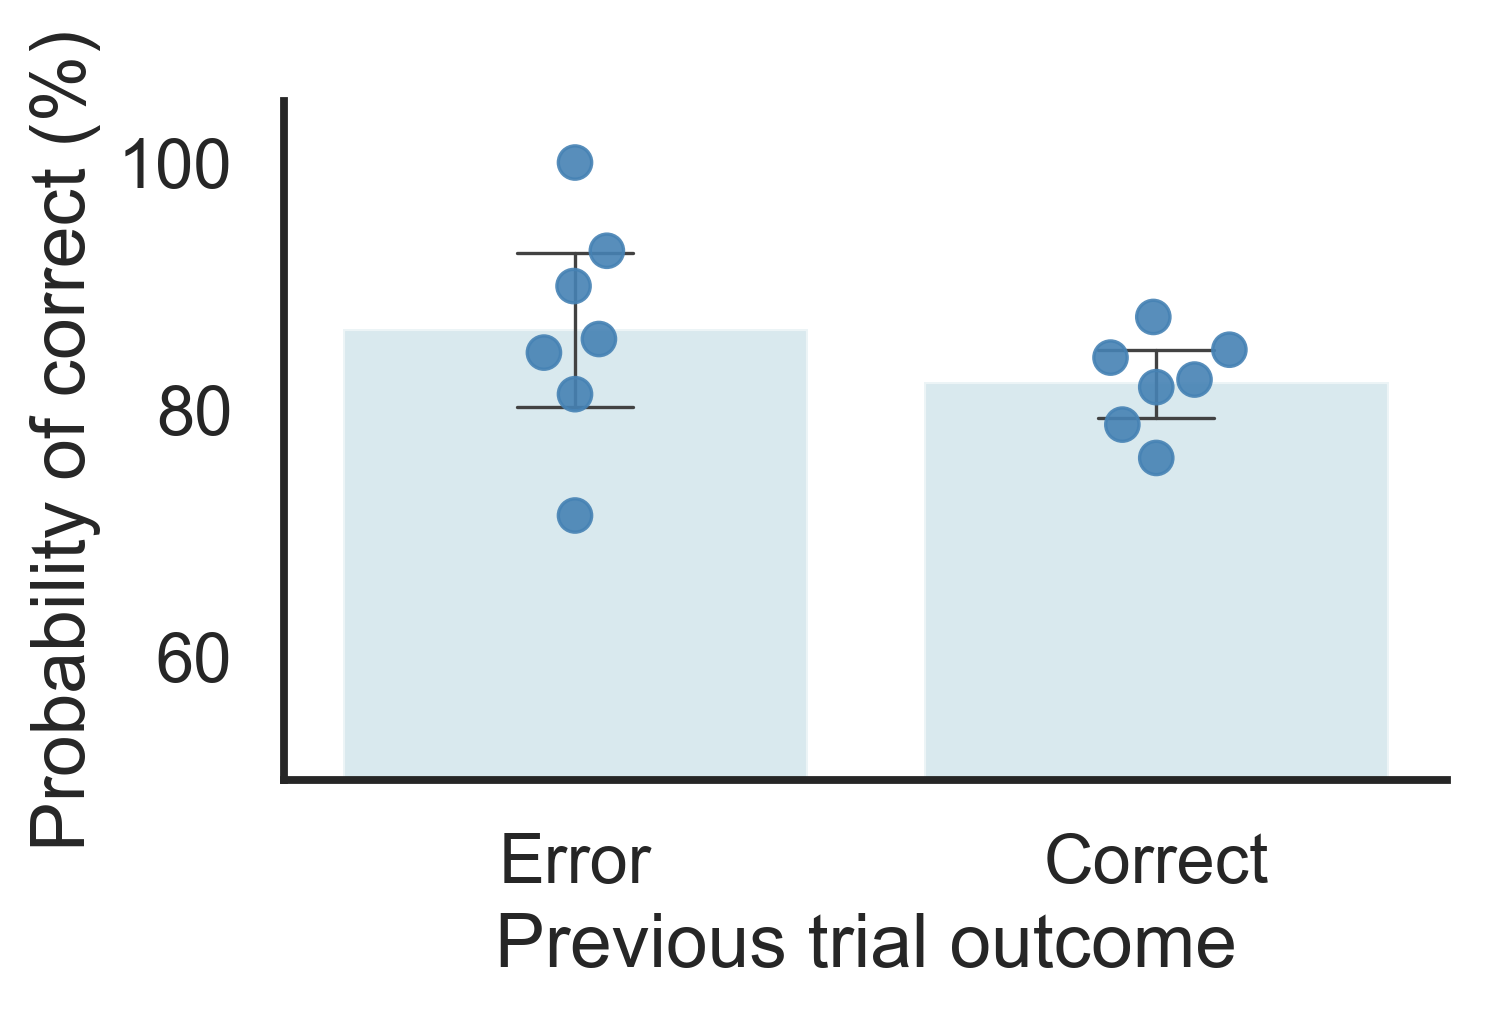

In [65]:
sns.set(style="white", context='talk')
plt.figure(figsize=(5,3), dpi=300)

a = sns.barplot(
    x='t-1_outcome', y='outcome', data=prob,
    palette=['lightblue'], alpha=.5,
    errwidth=.8, capsize=.2, linewidth=1, edgecolor='w'
)

b = sns.swarmplot(
     x='t-1_outcome', y='outcome', data=prob,
     palette=['steelblue'],
     edgecolor=None, alpha=.9, linewidth=.8,
     s=8, dodge=True
   
)

a.set(
    ylabel='Probability of correct (%)', xlabel='Previous trial outcome',
    ylim=(50, 105), xlim=(-0.5, 1.5)
)

#a.legend_.remove()
a.set_xticklabels(labels=['Error', 'Correct'], rotation=0)
sns.despine()
plt.show()

# 2.
***
### Probability of performing a correct trial given the sample side in the current trial
***

In [66]:
sums = trials.groupby(['group', 'rat','sample'])['outcome'].sum()
total = trials.groupby(['group', 'rat', 'sample'])['outcome'].count()
prob = ((sums/total)*100).reset_index()

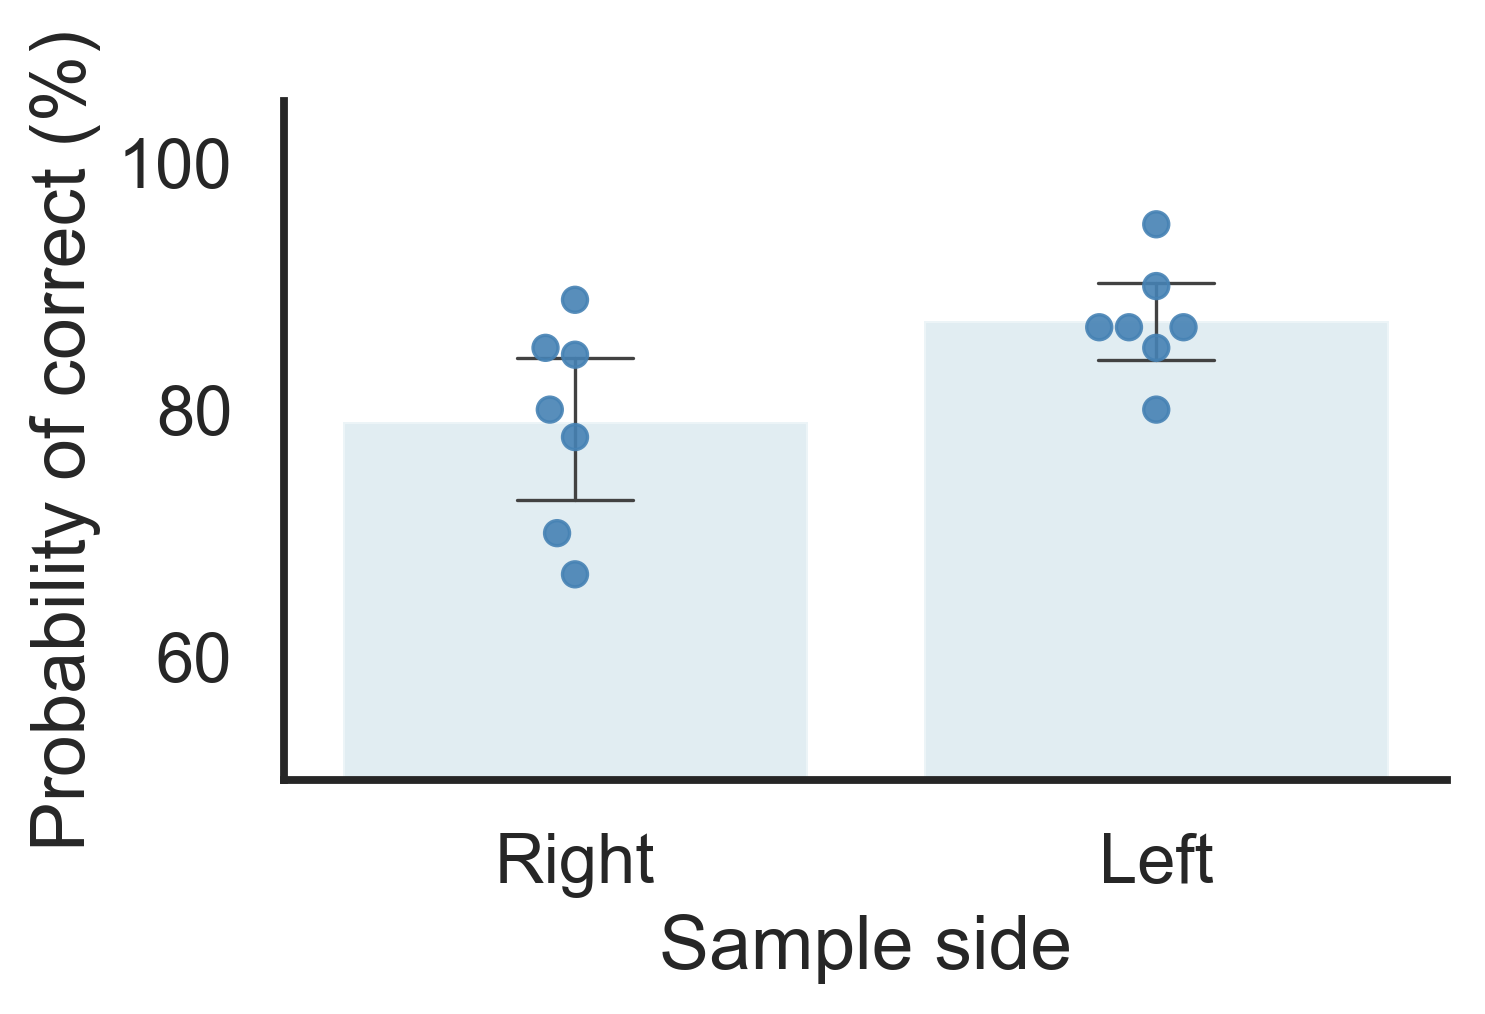

In [68]:
sns.set(style="white", context='talk')
plt.figure(figsize=(5,3), dpi=300)

a = sns.barplot(
    x='sample', y='outcome', data=prob,
    palette=['lightblue'], alpha=.4,
    errwidth=.8, capsize=.2, linewidth=1, edgecolor='w'
)

b = sns.swarmplot(
     x='sample', y='outcome', data=prob,
     palette=['steelblue'],
     edgecolor=None, alpha=.9, linewidth=.8,
     s=6, dodge=True
   
)

a.set(
    ylabel='Probability of correct (%)', xlabel='Sample side',
    ylim=(50, 105), xlim=(-0.5, 1.5)
)

#a.legend_.remove()
a.set_xticklabels(labels=['Right', 'Left'], rotation=0)
sns.despine()
plt.show()